In [24]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline
num_of_years = 11
start = dt.datetime.now() - dt.timedelta(int(365.25 * num_of_years))
end = dt.datetime.now() 
ticker = input("Enter a ticker: ")
tickers = []
df=web.DataReader(ticker,'yahoo',start,end) 
df

Enter a ticker: AMD


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-08-18,3.580000,3.490000,3.550000,3.560000,23269700,3.560000
2009-08-19,3.530000,3.470000,3.490000,3.520000,10937500,3.520000
2009-08-20,3.550000,3.490000,3.530000,3.520000,6528900,3.520000
2009-08-21,3.710000,3.510000,3.530000,3.700000,20133600,3.700000
2009-08-24,4.100000,3.880000,3.930000,4.000000,49755000,4.000000
...,...,...,...,...,...,...
2020-08-11,80.709999,76.099998,80.709999,76.879997,77877700,76.879997
2020-08-12,82.879997,77.550003,78.430000,82.610001,88607800,82.610001
2020-08-13,84.019997,81.540001,82.879997,81.839996,57407400,81.839996


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel

Trading statistics are from 2009-08-19 02:29:06.769580 up till now with 9 trades:
=======Performance Metrics=======
Total return over 9 trades: 412.85%
Annualized Total return 0.8267717882228227
Sharpe Ratio:1.0031642355450907
Maximum drawdown: -50.12134474234051%
Maximum drawdown Period: 1095.0days
Gain/loss ratio: 7.998566935607898
Total return for a Buy and Hold strategy: 424.13%
Average Gain: 154.97%
Average Loss: -19.37%
Max Return: 489.2857125479695%
Max Loss: -37.82771838248268%
Cumulative 



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


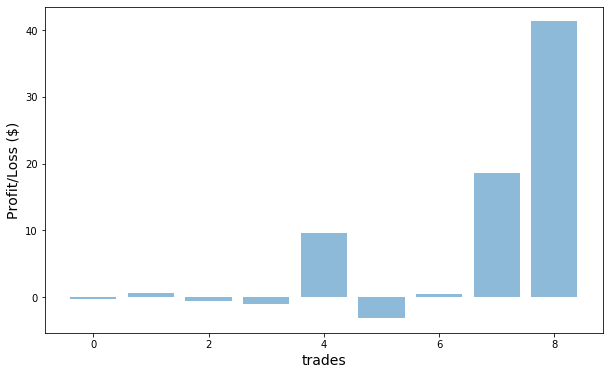

In [25]:
trade(df)

## Calculating Hurst

In [2]:
from numpy import log10, polyfit, var, subtract

def hurst_function(ts, lag_range=None):
    ts = ts if not isinstance(ts, pd.Series) else ts.to_list()
    
    if len(ts)>250:
        ts = log10(ts) # use log price
        variancetau = []
        tau = []
        #  Range of lag values
        if lag_range == None:
            lags = [2]
        else:
            lags = range(2, lag_range) # lag_range < len(ts)

        for lag in lags: 

            #  Write the different lags into a vector to compute a set of tau or lags
            tau.append(lag)

            # The price difference
            pp = subtract(ts[lag:], ts[:-lag])
            variancetau.append(np.std(pp))

            # Plot the log of corrseponding variance against the log of tau and get the slope
        m = polyfit(log10(tau),log10(variancetau),1)

        hurst = m[0]

        return hurst*1.3
    else:
        return 0

hurst_function(df['Adj Close'],50)



0.6497868512640183

In [3]:
def momentum(ts):
    returns=np.log(ts)
    x=np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x,returns)
    score=((1+slope)**252)*(rvalue**2)
    return score

## Initialize Trade Function

In [23]:
def trade(ts):
    df=ts
    df['Ownreturn']=df['Adj Close'].pct_change(1)
    df['MomentumLag']=df['Adj Close'].rolling(90).apply(momentum)
    df['MomentumHold']=df['Adj Close'].rolling(25).apply(momentum)
    df['MomentumPos']=None
    df['Buy_Signal_Price']=None
    df['Sell_Signal_Price']=None
    df['Hurst']=None
    tradingRange=252
    rangeLook=25
    for row in range(len(df)):
        if row > tradingRange:
            df['Hurst'].iloc[row]=hurst_function(df['Adj Close'].iloc[row-tradingRange:row],rangeLook)
        else:
            df['Hurst'].iloc[row]=0
    df=df.iloc[tradingRange+1:]     

    for row in range(len(df)): #position long or short
        
        if(df['Hurst'].iloc[row]>0.5):
            if(((df['MomentumLag'].iloc[row] > 0) and (df['MomentumHold'].iloc[row] > 0))):
                df['MomentumPos'].iloc[row]=1
            elif (((df['MomentumLag'].iloc[row] > 0) and (df['MomentumHold'].iloc[row] < 0))):
                df['MomentumPos'].iloc[row]=0
        
            elif(((df['MomentumLag'].iloc[row] < 0) and (df['MomentumHold'].iloc[row] < 0))):
                df['MomentumPos'].iloc[row]=-1  
            elif (((df['MomentumLag'].iloc[row] <0) and (df['MomentumHold'].iloc[row] > 0))):
                df['MomentumPos'].iloc[row]=0
        else:
            df['MomentumPos'].iloc[row]=0
    position=0 #1 means we enter positions, 0 nomeans not ealready entered
    counter=0
    percentChange=[]
    pnl=[]
    #Start of trading day minus the first lag use to calculate the momentum period
    
    momentumPos=df['MomentumPos'] 
    for i in df.index:
        
         #for daily return
        close=df['Adj Close'][i]
        
        if(momentumPos[i]==1):
            if(position==0): #buy
                buyP=close
                position=1
                df['Buy_Signal_Price'][i]=buyP
                df['Sell_Signal_Price'][i]=np.nan
        elif(momentumPos[i]==-1):
            if(position==0): #short
                position=-1
                sellP=close
                df['Buy_Signal_Price'][i]=np.nan
                df['Sell_Signal_Price'][i]=sellP
        elif(momentumPos[i]==0):
            if(position==1): #Sell current poisition
                position=0 #selling position
                sellP=close #selling price
                perc=(sellP/buyP-1)*100
                p=sellP-buyP
                pnl.append(p)
                percentChange.append(perc)
                df['Buy_Signal_Price'][i]=np.nan
                df['Sell_Signal_Price'][i]=sellP
            elif(position==-1):#covering short position
                position=0 #buying position
                buyP=close #buy price
                perc=(sellP/buyP-1)*100
                p=sellP-buyP
                pnl.append(p)
                percentChange.append(perc)
                df['Buy_Signal_Price'].iloc[i]=buyP
                df['Sell_Signal_Price'].iloc[i]=np.nan
        else:
            df['Buy_Signal_Price'].iloc[i]=np.nan
            df['Sell_Signal_Price'].iloc[i]=np.nan
        
        #if we stil have long or short position in the end, exit it      
        if(counter==df['Adj Close'].count()-1 and position==1):
            position=0
            sellP=close
            perc=(sellP/buyP-1)*100
            percentChange.append(perc)
            p=sellP-buyP
            pnl.append(p)
        elif(counter==df['Adj Close'].count()-1 and position==-1):
            position=0
            buyP=close
            perc=(sellP/buyP-1)*100
            percentChange.append(perc)
            p=sellP-buyP
            pnl.append(p)
        
        
        counter+=1
    #Daily Return 
    
    daily_ret=df['Adj Close'].pct_change()*df['MomentumPos'].shift(1)
    cum_ret=1*(1+daily_ret).cumprod()
    #Annualized sharpe ratio
    sharpe=(np.mean(cum_ret))/np.std(cum_ret)
    
    gains=0
    numGains=0
    losses=0
    numLosses=0
    totReturn=round(daily_ret.sum()*100,2)
    
    for i in percentChange:
        if(i>0):
            gains+=i
            numGains+=1
        else:
            losses+=i
            numLosses+=1
        #totReturn=totReturn**((i/100)+1)
    #totReturn=round((totReturn-1)*100,2)
    
    print("Trading statistics are from "+str(start)+" up till now with " +str(numGains+numLosses)+" trades:")
    
    if (numGains>0):
        avgGain=gains/numGains
        maxReturn=str(max(percentChange))
    else:
        avgGain=0
        maxReturn.np.nan
    
    if(numLosses>0):
        avgLoss=losses/numLosses
        maxLoss=str(min(percentChange))
        ratioRR=str(-avgGain/avgLoss) #risk-reawrd ratio
    else:
        avgLoss=0
        maxLoss=np.nan
        ratioRR='inf'
    
    df['PC']=df['Adj Close'].pct_change()
    hold=round(df['PC'].sum()*100,2)
    print ("=================Performance Metrics==============")
    print("Total return over " +str(numGains+numLosses)+" trades: "+ str(totReturn)+"%")
    print("Annualized Total return "+ str(annualize_return(totReturn)))
    print("Sharpe Ratio:" + str(sharpe))
    calculateMaxDD(cum_ret)
    print("Gain/loss ratio: "+ str(ratioRR))
    print("")
    print("================Trading Statistics===================")
    print ("Total return for a Buy and Hold strategy: " + str(hold)+'%')
    print("Average Gain: "+ str(round(avgGain, 2))+"%")
    print("Average Loss: "+ str(round(avgLoss, 2))+"%")
    print("Max Return: "+ str(maxReturn)+"%")
    print("Max Loss: "+ str(maxLoss)+"%")
    print("")
    
   
    
    if(numGains>0 or numLosses>0):
        batAvg=numGains/(numGains+numLosses)
    else:
        batAvg=0
    
    #print("Batting Average: "+str(batAvg))
    
    fig=plt.figure(figsize=(10,6))
    x=range(len(pnl))
    plt.bar(x,pnl,alpha=0.5)
    plt.xlabel('trades',fontsize=14)
    plt.ylabel('Profit/Loss ($)', fontsize=14)
    plt.show()
    

## Signal Buy and Sell Assets for Visualizations

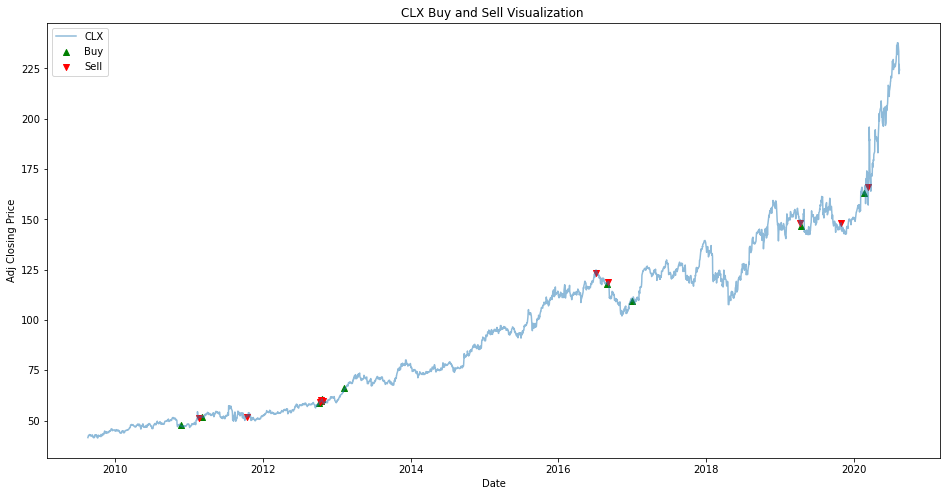

In [123]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'],label=ticker,alpha=0.5)
plt.scatter(df.index,df['Buy_Signal_Price'],label='Buy',marker='^',color='green')
plt.scatter(df.index,df['Sell_Signal_Price'],label='Sell',marker='v',color='red')
plt.title(ticker +' Buy and Sell Visualization ')
plt.xlabel('Date')
plt.ylabel('Adj Closing Price')
plt.legend(loc='upper left')


## Cumulative return Performance

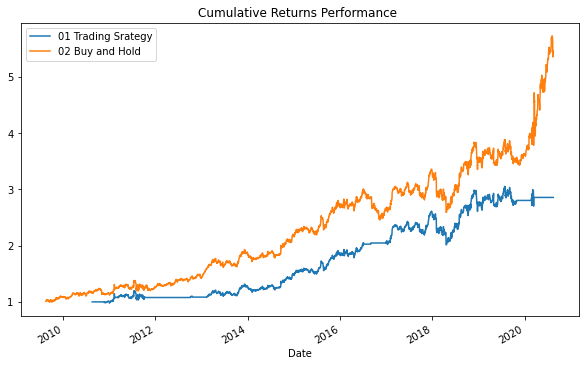

In [124]:

def cumulative_return(ts):
    df=ts
    df['01 Trading Srategy']=1*(1+df['Adj Close'].pct_change()*df['MomentumPos'].shift(1)).cumprod()
    df['02 Buy and Hold']=1*(1+df['Ownreturn']).cumprod()
    df[['01 Trading Srategy','02 Buy and Hold']].plot(label='tesla',figsize=(10,6))
    plt.title('Cumulative Returns Performance ')
    
cumulative_return(df)

In [6]:
df=df.iloc[253:] #remove nan value

def annualize_return(total_return):
    year=10 #Specified
    return ((1+total_return)**(1/year))-1



## Calculate MaxDrawdown period

In [9]:
def calculateMaxDD(cumret):
    highwatermark=np.zeros(len(cumret))
    drawdown=np.zeros(len(cumret))
    drawdownduration=np.zeros(len(cumret))
    for t in range(1,len(cumret)):
        highwatermark[t]=np.max([highwatermark[t-1], cumret[t]])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if (drawdown[t]==0):
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    print ("Maximum drawdown: "+str(np.min(drawdown)*100)+"%")
    print ("Maximum drawdown Period: "+str(np.max(drawdownduration))+"days")
    
#calculateMaxDD(df['01 Trading Srategy'])


### Test the program 

In [ ]:
def testing_program(tickers):
    x = []
    for ticker in tickers:
        print('Trading on: {}'.format(ticker))
        data,beta, risk, sharpe, ret, profit = trade(data)
        temp = {
            'ticker':ticker,
            'beta':beta,
            'risk':risk,
            'sharpe': sharpe,
            'return':ret,
            'profit':profit
        }
        x.append(temp)
        
    df = pd.DataFrame(x, columns=['ticker','beta','risk','sharpe','return','profit'])
        
    return df

In [ ]:
df

### Test 100 random Company in the data file

In [ ]:
def select_random(tickers, num):
    test_companies = []
    already_used = []
    for i in range(0,num):
        pos = random.randint(0,len(tickers)-1)
        
        while True:
            if pos in already_used:
                pos = random.randint(0,len(tickers))
            else:
                already_used.append(pos)
                break
            
        test_companies.append(tickers[pos])
    
    return test_companies

def test_100():
    companies = pd.read_csv('constituents.csv')
    tickers = companies['Symbol'].tolist()
    for n, i in enumerate(tickers):
        if i == 'BRK.B':
            tickers[n] = 'BRK'
        if i == 'BF.B':
            tickers[n] = 'BF'

    companies = select_random(tickers, 100)
    df = testing_program(companies, model)
    df.to_csv('Backtest_100_Stocks.csv')